<a href="https://colab.research.google.com/github/Olesya-Oleksyuk/Two-Dimensional-Schelling-Model/blob/main/SegregationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Документ с детальным описанием одномерной модели сегрегации Шеллинга, с выводами по результатам её работы (написано на основе оригинальной статьи Шеллинга): https://docs.google.com/document/d/1cXJanTtr9DQKrVDiqM91dEn-sma5t-A7/edit#

In [ ]:
from scipy.signal import correlate2d
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from time import sleep
from IPython.display import clear_output

# Класс 2-D **клеточного автомата**, на основе которого строится модель Шеллинга

In [ ]:
class Cell2D:
    """Базовый класс для построения 2-D клеточнего автомата."""

    def __init__(self, n, m=None):
        """Инициализация атрибутов

        n: количество строк
        m: количество столбцов
        """
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        """Добавление клеток в заданную локацию

        row: вернхий индекс строки
        col: левый индекс столбца
        strings: список строк из 0 и 1
        """
        for i, s in enumerate(strings):
            self.array[row + i, col:col + len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1, show_segregation_steps = None):
        """Запуск заданного количества шагов
        iters: количество шагов перемещений агентов
        show_segregation_steps (True): вывести значение степени сегрегации системы после шага
        """
        for i in range(1, iters+1):
            if show_segregation_steps == True:
                 print('шаг ', i)
            self.step(show_segregation_steps)

    def draw(self, **options):
        """Отрисовка массива"""
        draw_array(self.array, **options)

    def animate(self, frames, interval=None, step=None):
        """Анимация автомата

        frames: количество шагов моделирования
        interval: время между фреймами в секундах
        step: функция, реализующая 1 шаг перемещений
        """
        if step is None:
            step = self.step

        try:
            for i in range(frames - 1):
                self.draw(animation=True)
                plt.show()
                if interval:
                    sleep(interval)
                step()
                clear_output(wait=True)
            self.draw(animation=True)
            plt.show()
        except KeyboardInterrupt:
            pass

# Вспомогательные функции для отрисовки графиков

In [ ]:
def draw_array(array, animation=None, **options):
    """Отрисовка клеток"""
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])
    if animation == True:
      plt.figure(figsize=(10,10))
    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])
    
    return plt.imshow(array, **options)



# mpl.rcParams['lines.linewidth'] = 2.0


def three_frame(world, n_seq, seed=17, show_segregation_steps = None):
    """Отрисовка снимков 3х состояний сегрегации системы

    world: объект класса Schelling с функциями step, loop, and draw
    n_seq: картеж из 3 значений, количество шагов перед каждым снимком
    seed: случайное see для NumPy
    """
    np.random.seed(seed)
    plt.subplots(figsize=(20, 20))
    for i, n in enumerate(n_seq):
        # plt.figure(figsize=(10,10))
        plt.subplot(1, 3, i + 1)
        plt.title(f"{n} шагов")
        world.loop(n, show_segregation_steps)
        world.draw()

    plt.tight_layout()

def underride(d, **options):
    """Добавление пар ключ-значение в словарь-опций (d), если ключа нет в d
    d: словарь с опциями для графика
    options: ключевые слова args для добавление в словарь-опций d
    """
    for key, val in options.items():
        d.setdefault(key, val)
    return d


def decorate(**options):
    """Декорирование осей графика

    Вызов декорирования с агрументами-опциями вида:
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    Агрументы-опции могут быть любыми из опций декорирования осей
    https://matplotlib.org/api/axes_api.html

    Дополнительно, вы можете использовать `legend=False` для отключения легенды

    Используйте `loc` для указания положения легенды на графике
    (значение по-умолачанию - 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    # plt.figure(figsize=(10, 6))
    plt.tight_layout()


def legend(**options):
    """Отрисовка легенды, если есть хотя бы 1 элемент с лейблом.
    опции передаются в plt.legend()
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
    """
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)


def set_palette(*args, **kwds):
    """Задание цвеовой паллитры для matplotlib

    args, kwds: то же что и для sns.color_palette

    Также принимает kwd (boolean), `reverse`, для обозначения того
    будет ли порядок цветов паллитры обратным

    returns: список цветов
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)

    palette = list(palette)
    if reverse:
        palette.reverse()

    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette


def locs_where(condition):
    """ Находит клетки, где логический массив равен True (is True)
    condition: логический массив
    returns: список из кортежей местоположения (list of location tuples)
    """
    return list(zip(*np.nonzero(condition)))

# Класс модели сегрегации Шеллинга 
## **Терминология**: 

*  *Похожие соседи* - это соседи того же цвета, что и исследуемый агент.
*  *Порог толерантности* - исходная минимальная требуемая доля агентов того же цвета в соседстве (для каждого из агентов)
*  *Степень сегрегации* - итоговая усредненная доля похожих соседей для каждой клетки карты.




In [ ]:
class Schelling(Cell2D):
    """Представление сетки для агентов Шеллинга"""

    # для функции correlate2d:
    # параметры same - результат будет того же размера, что и входные данные
    # wrap - верхний край сворачивается так, чтобы соответствовать нижнему,
    # а левый край – правому.
    options = dict(mode='same', boundary='wrap')
    # указываем, что соседство = 8 агентам
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)

    def __init__(self, n, p):
        """Инициализация агентов на сетке.

        n: количество строк и столбцов (= размер сетки)
        p: порог толерантности (минимальная доля агентов того же цвета в соседстве)
        напр. если p = 0.3, то агенты цвета Х
        будут довольны, когда 30% или более соседей цвета Х.
        """
        self.p = p
        # 0 -пустая клетка, 1 - красный агент, 2 - синий агент
        choices = np.array([0, 1, 2], dtype=np.int8)
        # распределение типов клеток: 10% - пустые, по 45% синих и красных
        probs = [0.1, 0.45, 0.45]
        # сгенерированная карта
        self.array = np.random.choice(choices, (n, n), p=probs)
        # текущая усредненная степень сегрегации модели
        self.current_segregation = self.segregation()

    def count_neighbors(self):
        """Исследование соседних клеток

        returns: кортежи (пустые клетки; доли красных; доли синих; доли одинаковых)
            empty: логический кортеж, в котором True соответствует пустой клетке
            frac_red: доли красных соседей вокруг каждой клетки
            frac_blue:  доли синих соседей вокруг каждой клетки
            frac_same: доли похожих соседей
        """
        a = self.array

        # формируем логические массивы
        # пустые ячейки на карте
        empty = a == 0
        # красные ячейки на карте
        red = a == 1
        # синие ячейки на карте
        blue = a == 2

        # подсчитываем красных и синих соседей для каждого местоположения
        num_red = correlate2d(red, self.kernel, **self.options)
        num_blue = correlate2d(blue, self.kernel, **self.options)
        num_neighbors = num_red + num_blue

        # вычисляем доли красных/синих соседей для каждого агента
        frac_red = num_red / num_neighbors
        frac_blue = num_blue / num_neighbors

        # учитываем редкий случай:
        # принимаем отсуствие соседей в окрестности равным отсуствию похожих соседей
        frac_red[num_neighbors == 0] = 0
        frac_blue[num_neighbors == 0] = 0

        # каждому агенту присваиваем долю соседей того же цвета, что и агент
        frac_same = np.where(red, frac_red, frac_blue)

        # для пустых клеток, frac_same получает NaN
        frac_same[empty] = np.nan

        return empty, frac_red, frac_blue, frac_same

    def segregation(self):
        """Расчет итоговой степени сегрегации, являющейся средней по агентам

        returns: доля похожих соседей, усредненная для каждой клетки
        """
        _, _, _, frac_same = self.count_neighbors()
        self.current_segregation = np.nanmean(frac_same)
        return self.current_segregation

    def step(self, show_segregation_steps = None):
        """функция, реализующая перестановку всех недовольных агентов 
        show_segregation_steps (True): вывести значение степени сегрегации системы после шага

        returns: долю одинаковых соседей, усредненную для каждой клетки
        """
        a = self.array
        empty, _, _, frac_same = self.count_neighbors()

        # поиск недовольных агентов (игнорируем NaN в frac_same)
        with np.errstate(invalid='ignore'):
            unhappy = frac_same < self.p
        unhappy_locs = locs_where(unhappy)

        # поиск координат пустых клеток
        empty_locs = locs_where(empty)

        # перемешиваем клетки с несчастными агентами
        if len(unhappy_locs):
            np.random.shuffle(unhappy_locs)

        # для каждого несчастного агента выбираем случайную пустую клетку для перемещения
        num_empty = np.sum(empty)
        for source in unhappy_locs:
            i = np.random.randint(num_empty)
            # координаты пустой случайной клетки, куда перемещаемся
            dest = empty_locs[i]

            # перемещение
            a[dest] = a[source]
            a[source] = 0
            empty_locs[i] = source

        # проверка: количество пустых клеток должно остаться прежним
        num_empty2 = np.sum(a == 0)
        assert num_empty == num_empty2
        
        self.current_segregation = np.nanmean(frac_same)
        
        if show_segregation_steps == True:
            print('полученная степень сегрегация на шаге frac_same: ',round(self.current_segregation,3))
        
        # возвращаем усредненное значение долей одинаковых соседей
        return self.current_segregation

    def draw(self, animation=None):
        """Отрисовка ячеек для визуализации
        animation (True): отрисовка для анимации
        """
        return draw_array(self.array, animation, cmap=cmap, vmax=2)

In [ ]:
# создаем пользовательскую цветную карту
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)

# **Настройка модели сегрегации**
## Введите данные для генерирования случайной карты для модели сегрегации:


*   n - размер карты (n x n)
*   p - параметр порога толерантности (минимальная доля агентов того же цвета в соседстве)
  * напр. если p = 0.3, то агенты цвета Х
        будут довольны, когда 30% или более соседей цвета Х.


*Настройки отрисовки карты:*
*   w - ширина холста (дюймы)
*   h - высота ходста (дюймы)
*   dpi - плотность пикселей холста




Исходный параметр порога толерантности: 0.4
Исходная усредненная степень сегрегации 0.503


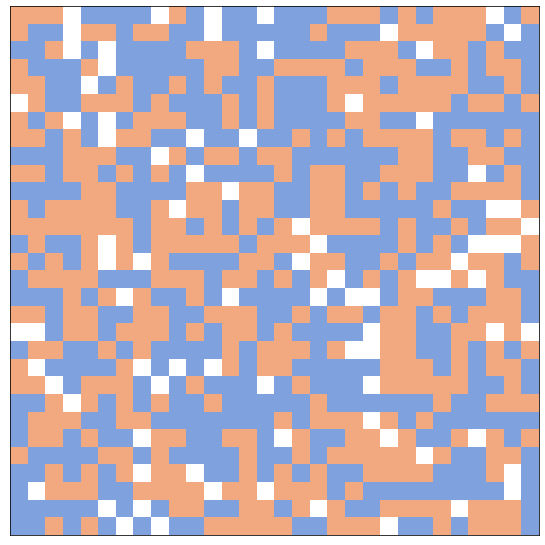

In [ ]:
n = 30
p = 0.4

# настройка отрисовки (лучше оставить настройки по-умолчанию):
w = 10
h = 10
dpi = 70

# позволяет в каждой из ячеек генерировать один и тот же 
# исходный случайный порядок агентов 
np.random.seed(17) 
grid = Schelling(n=n, p=p)
# отрисовка сгенерированной карты
plt.figure(figsize=(w, h), dpi=dpi)
grid.draw()
print('Исходный параметр порога толерантности:', p)
print('Исходная усредненная степень сегрегации', round(grid.current_segregation,3))


## Запуск модели 
### Способ 1: запуск функции шага перемещения агентов - *step()* внутри цикла for 

*Пример*:
for i in range(1, 4) - позволяет запустить 3 раунда (шага) перемещения агентов

In [ ]:
# позволяет в каждой из ячеек генерировать один и тот же 
# исходный случайный порядок агентов 
np.random.seed(17) 

grid = Schelling(n=n, p=p)

for i in range(1, 4):
    print('шаг ', i)
    grid.step(show_segregation_steps=True)
    
# grid.loop(iters=3)
print('\nИтоговая степень сегрегации: ', round(grid.current_segregation,3))
    
# print('Итоговая степень сегрегации: ', grid.segregation())

шаг  1
полученная степень сегрегация на шаге frac_same:  0.503
шаг  2
полученная степень сегрегация на шаге frac_same:  0.612
шаг  3
полученная степень сегрегация на шаге frac_same:  0.686

Итоговая степень сегрегации:  0.686


### Способ 2: запуск функции раунда перемещения агентов - *loop(iters)* с указанием количества шагов (без указания iters запускается 1 шаг)

*Пример*:
grid.loop(3, show_segregation_steps)- позволяет запустить 3 раунда (шага) перемещения агентов

In [ ]:
# позволяет в каждой из ячеек генерировать один и тот же 
# исходный случайный порядок агентов 
np.random.seed(17) 

grid = Schelling(n=n, p=p)

grid.loop(3, show_segregation_steps = True)
print('\nИтоговая степень сегрегации: ', round(grid.current_segregation, 3))

шаг  1
полученная степень сегрегация на шаге frac_same:  0.503
шаг  2
полученная степень сегрегация на шаге frac_same:  0.612
шаг  3
полученная степень сегрегация на шаге frac_same:  0.686

Итоговая степень сегрегации:  0.686


## Анимация моделирования перемещения агентов (образования сегрегации)
*   количество шагов задаётся параметром frames
*   как только все агенты оказываются счастливы (довольны долей похожих агентов в соседстве) - агенты прекращают перемещение (несмотря на оставшееся количество шагов)

*Степень сегрегации быстро возрастает с каждым шагом*.


---

### ⚠️ Внимание: для запуска анимации - перезапустить ячейку ниже



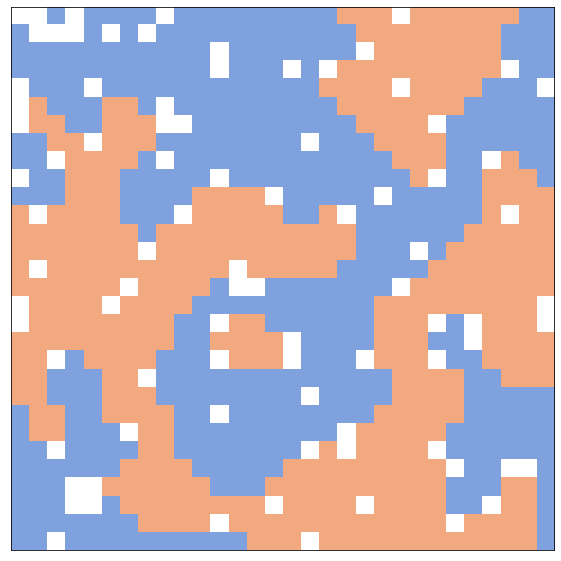

Исходный параметр порога толерантности: 0.4
Итоговая степень сегрегации:  0.846


In [ ]:
# позволяет в каждой из ячеек генерировать один и тот же 
# исходный случайный порядок агентов 
np.random.seed(17) 
grid = Schelling(n=n, p=p)

grid.animate(frames=30, interval=0.1)

# получение итоговой степени сегрегации 
print('Исходный параметр порога толерантности:', p)
print('Итоговая степень сегрегации: ', round(grid.current_segregation, 3))

## Снимки состояния системы на разных этапах 
*   steps - список, состоящий из 3х значений, каждое из которых - количество шагов перемещений агентов перед фиксацией снимка.


шаг  1
полученная степень сегрегация на шаге frac_same:  0.503
шаг  2
полученная степень сегрегация на шаге frac_same:  0.618
шаг  1
полученная степень сегрегация на шаге frac_same:  0.702
шаг  2
полученная степень сегрегация на шаге frac_same:  0.743
шаг  3
полученная степень сегрегация на шаге frac_same:  0.76
шаг  4
полученная степень сегрегация на шаге frac_same:  0.781
шаг  5
полученная степень сегрегация на шаге frac_same:  0.8
шаг  6
полученная степень сегрегация на шаге frac_same:  0.81
шаг  7
полученная степень сегрегация на шаге frac_same:  0.818
шаг  8
полученная степень сегрегация на шаге frac_same:  0.826
шаг  9
полученная степень сегрегация на шаге frac_same:  0.834
шаг  10
полученная степень сегрегация на шаге frac_same:  0.835
шаг  11
полученная степень сегрегация на шаге frac_same:  0.841
шаг  12
полученная степень сегрегация на шаге frac_same:  0.841
шаг  13
полученная степень сегрегация на шаге frac_same:  0.841
шаг  14
полученная степень сегрегация на шаге frac_same

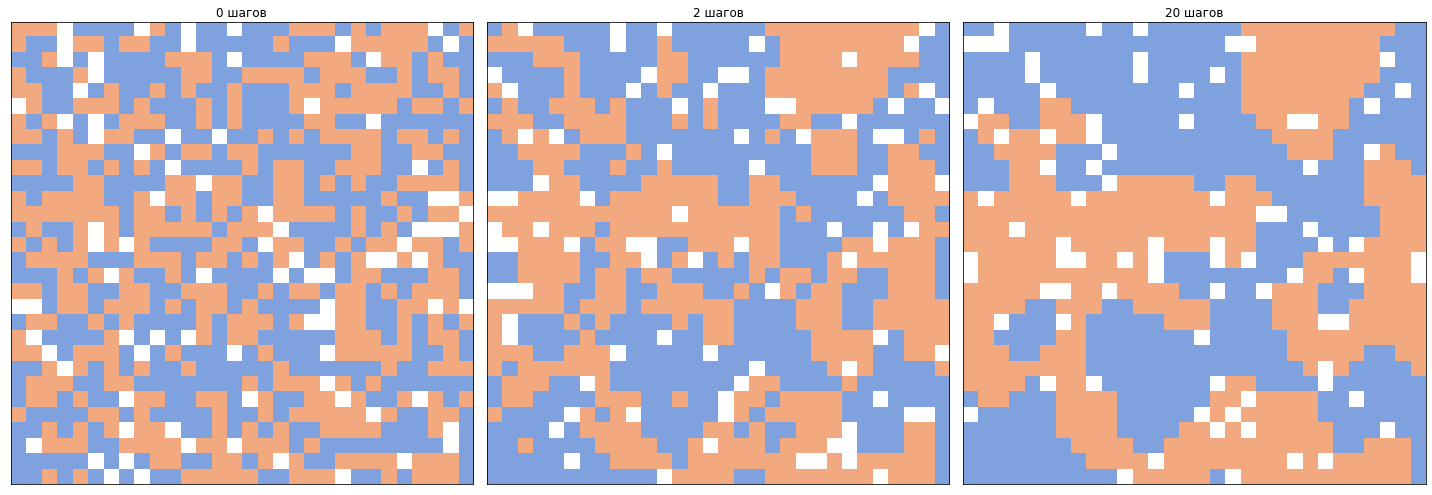

In [ ]:
# отобразить состояние соседей на начальном этапе, после 2х шагов, после 20 шагов
steps = [0, 2, 20]

# позволяет в каждой из ячеек генерировать один и тот же 
# исходный случайный порядок агентов 
np.random.seed(17) 
grid = Schelling(n=n, p=p)

three_frame(grid, steps, show_segregation_steps = True)

### Итог (на основе p и n значений по-умолчанию): 
На 11 шаге перемещения агентов прекращаются: все агенты довольны своим положением в соответствии с заданным порогом толерантности `p = 0.4` (40% похожих агентов в соседстве). Итоговая усредненная степень сегрегации составила `frac_same = 0.84` (в среднем 84% похожих агентов в соседстве)


## График зависимости степени сегрегации (*average_frac_same*) в модели Шеллинга от значения исходного порога толерантности (*p*)

Ниже представлена зависимость **итоговой степени сегрегации** в устойчивом состоянии системы от **исходного параметра толерантности p** (порог похожих соседей в соседстве, которое устроит агентов модели)

Порог толерантности  =  0.5 	 Итоговая степень сегрегации =  0.871 	 △ = 0.371
Порог толерантности  =  0.4 	 Итоговая степень сегрегации =  0.818 	 △ = 0.418
Порог толерантности  =  0.3 	 Итоговая степень сегрегации =  0.754 	 △ = 0.454
Порог толерантности  =  0.2 	 Итоговая степень сегрегации =  0.573 	 △ = 0.373


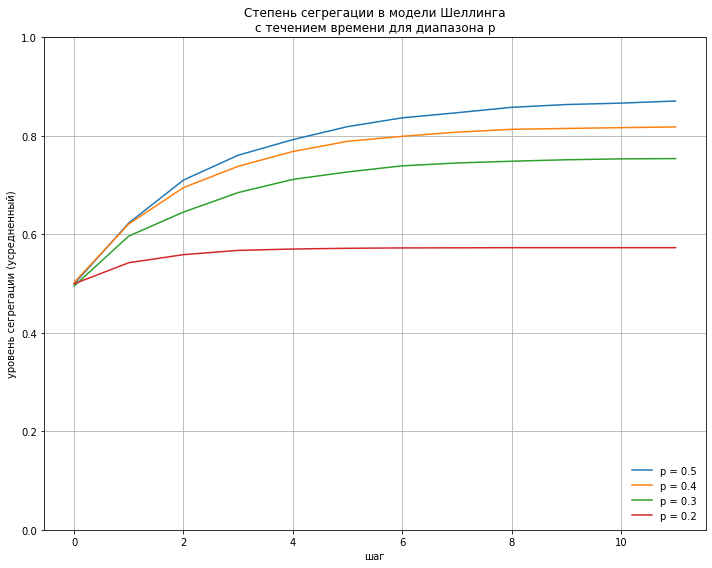

In [ ]:
np.random.seed(17)
plt.subplots(figsize=[10, 8])
for p in [0.5, 0.4, 0.3, 0.2]:
    grid = Schelling(n=100, p=p)
    segs = [grid.step() for i in range(12)]
    plt.plot(segs, label='p = %.1f' % p)
    print('Порог толерантности  = ', p, '\t Итоговая степень сегрегации = ', round(segs[-1],3), '\t △ =', round(segs[-1] - p,3))
decorate(xlabel='шаг', ylabel='уровень сегрегации (усредненный)', loc='lower right', ylim=[0, 1], title='Степень сегрегации в модели Шеллинга\nс течением времени для диапазона p')
plt.grid()
plt.show()

### Итог:
При значении `p = 0.4` наблюдается значительная разница между исходным показателем **p** толерантности (долей "похожих соседей", которая устраивает каждого отдельного агента системы) - всего **40%** агентов соседства должны быть "похожи", и той степенью сегрегации (усредненная доля похожих соседей для каждого агента), которую они действительно получают в результате совместных перемещений агентов внутри системы - около **82%** "похожих агентов" в соседстве. 

#### Эти результаты удивляют многих и служат ярким примером непредсказуемой взаимосвязи между индивидуальными решениями и поведением системы.